# Step 5: Experiment and Document 

## 1. Model Performance
- **XGBoost (Step 3, main model):**
  - Male: Test RMSE = 0.0772, MAE = 0.0650, MAPE = 9.14%
  - Female: Test RMSE = 0.0854, MAE = 0.0701, MAPE = 10.17%
- **Random Forest (this experiment):**
  - Male: RMSE = 0.0406, MAE = 0.0279, MAPE = 4.46%
  - Female: RMSE = 0.0395, MAE = 0.0301, MAPE = 4.36%

**Observation:**  
- Random Forest outperformed XGBoost on error metrics for both male and female datasets.  
- Performance differences suggest Random Forest may capture patterns more effectively, though model choice should not rely solely on metrics.  

---

## 2. Feature Importance and SHAP Insights
- **Male Dataset:**  
  - **XGBoost:** Top features included `GSR Resistance CAL_mean`, `Delta_TP9_mean`, `Eye Widen_mean`, `Theta_TP10_mean`.  
  - **RandomForest:** Top features shifted to `Anger_mean`, `GSR Resistance CAL_mean`, `Theta_TP9_mean`, `Eye Widen_mean`.  
  - **Comparison:** Both models emphasized GSR and EEG features, but Random Forest elevated facial expression features (`Anger_mean`, `Eye Widen_mean`) more prominently.  

- **Female Dataset:**  
  - **XGBoost:** Top features included `Smile_mean`, `ET_TimeSignal_mean`, `Row_mean`, `Delta_TP10_mean`.  
  - **RandomForest:** Top features shifted to `Smirk_mean`, `Lip Press_mean`, `Beta_AF7_mean`, `Lid Tighten_mean`.  
  - **Comparison:** Random Forest highlighted subtle facial cues (smirk, lip press) over EEG/time-signal features emphasized by XGBoost.  

**Observation:**  
- Both models captured consistent high-level signals but weighted feature categories differently:  
  - XGBoost leaned toward physiological/EEG and gaze features.  
  - Random Forest elevated micro-expressions (lip/mouth movements, smirk, anger).  

---

## 3. Gender-Specific Insights
- **Male Dataset:**  
  - Physiological signals (EEG and GSR) remained strong predictors across both models.  
  - Random Forest additionally highlighted facial expressions (`Anger_mean`, `Eye Widen_mean`), suggesting behavioral signals may add predictive value for males.  

- **Female Dataset:**  
  - XGBoost emphasized EEG and time-based features.  
  - Random Forest strongly highlighted micro-expressions (`Smirk_mean`, `Lip Press_mean`, `Lip Stretch_mean`), pointing to richer nonverbal behavioral cues among females.  

**Observation:**  
- Gender-specific SHAP patterns remain robust, but feature categories contributing most importance differ slightly by model.  
- This suggests complementary cognitive and behavioral strategies reflected in physiological vs. expressive signals.  

---

## 4. Limitations
- Findings are correlational, not causal.  
- Feature importance varies by algorithm, underscoring model dependence.  
- SHAP results highlight associations, but underlying mechanisms remain speculative.  


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
import matplotlib.pyplot as plt
import joblib

In [2]:
df_male = pd.read_csv("../data/participant_summary_male.csv")
df_female = pd.read_csv("../data/participant_summary_female.csv")

In [3]:
X_male, y_male = df_male.drop(columns=["Participant_ID", "Gender", "Mean_Accuracy", "Mean_ResponseTime"]), df_male["Mean_Accuracy"]
X_female, y_female = df_female.drop(columns=["Participant_ID", "Gender", "Mean_Accuracy", "Mean_ResponseTime"]), df_female["Mean_Accuracy"]

In [4]:
rf_male = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf_female = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)

rf_male.fit(X_male, y_male)
rf_female.fit(X_female, y_female)

# Save models
joblib.dump(rf_male, "../models/rf_model_male.pkl")
joblib.dump(rf_female, "../models/rf_model_female.pkl")

['../models/rf_model_female.pkl']

In [5]:
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # Avoid division by zero by adding a small epsilon
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return {
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    }

# Predictions
male_preds = rf_male.predict(X_male)
female_preds = rf_female.predict(X_female)

# Evaluate
male_scores = evaluate_model("RandomForest (Male)", y_male, male_preds)
female_scores = evaluate_model("RandomForest (Female)", y_female, female_preds)

# Results as DataFrame
results = pd.DataFrame([male_scores, female_scores])
results

,Model,RMSE,MAE,MAPE (%)
0,RandomForest (Male),0.040626,0.027933,4.460188
1,RandomForest (Female),0.039522,0.030127,4.361512


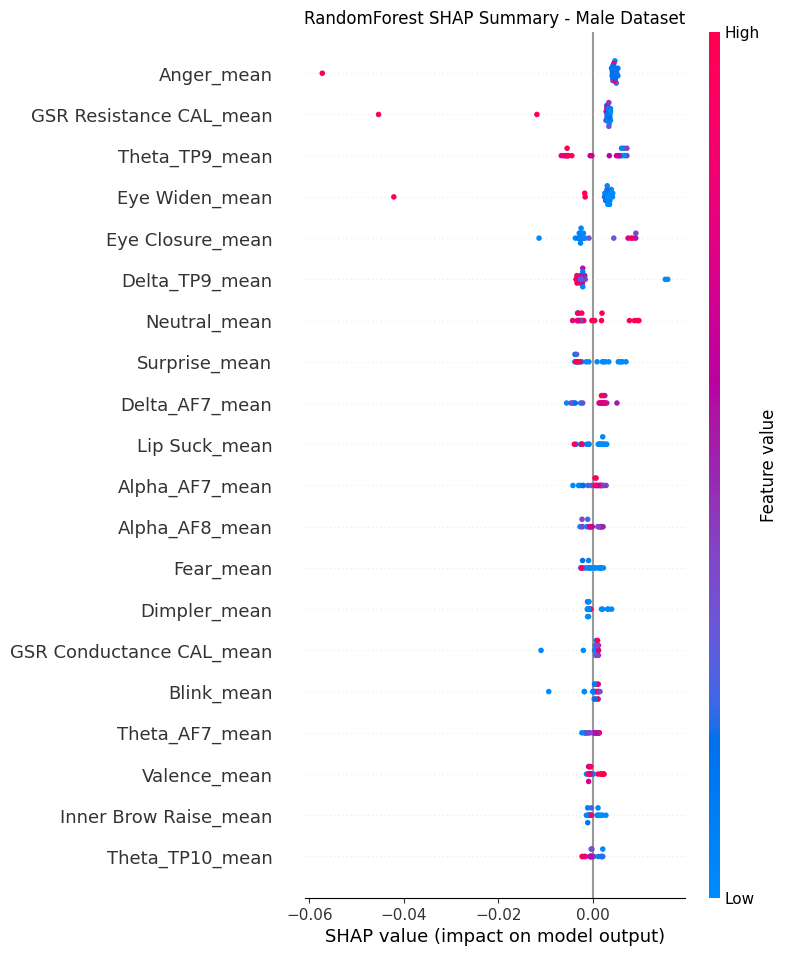

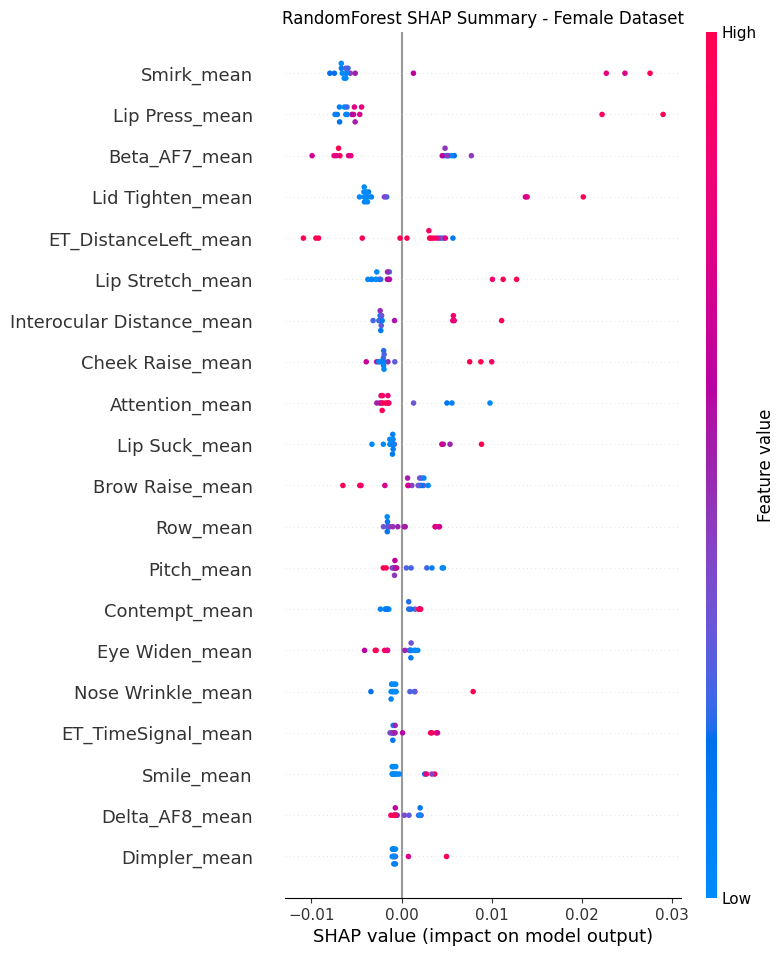

In [6]:
explainer_male = shap.TreeExplainer(rf_male)
explainer_female = shap.TreeExplainer(rf_female)

shap_values_male = explainer_male.shap_values(X_male)
shap_values_female = explainer_female.shap_values(X_female)

# SHAP summary plots
shap.summary_plot(shap_values_male, X_male, show=False)
plt.title("RandomForest SHAP Summary - Male Dataset")
plt.show()

shap.summary_plot(shap_values_female, X_female, show=False)
plt.title("RandomForest SHAP Summary - Female Dataset")
plt.show()